In [10]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# See block centroid allocation method described here: 
# https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks/block_centroid_allocation.ipynb
# NOTE: Don't need all of these!
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
from osgeo import osr, ogr
import pandas as pd
import psycopg2
from pyproj import Geod
import seaborn as sns
from shapely.geometry import Polygon
import sys
# Import modules NOT included in "kitchen-sink", not sure about osgeo...
from dotenv import load_dotenv, find_dotenv # install python-dotenv
import geoplot as gplt   # requires cython

%matplotlib inline

F.D. Pearce, 04/16/18

Notebook for computing statistics on raster pixel values contained within a geometry (shape) file

In [68]:
# Define ALL parameters in dictionary (convert to json config file!)
params = {
    'geometry_in': {
        'from_postgis': {
            # You MUST have a .env file specifying parameters for postgis db in order to
            # read data in from postgis! See sample_env.txt at 
            # https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks
            'query': {
                'string': '''
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.bldg_lr AS buildingloss_ratio_wet,
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulation_wet,
                        lnuw.pdsnone AS buildings_nodamage_wet,
                        lnuw.pdsslight AS buildings_slightdamage_wet,
                        lnuw.pdsmoderate AS buildings_moderatedamage_wet,
                        lnuw.pdsextensive AS buildings_extensivedamage_wet,
                        lnuw.pdscomplete AS buildings_completedamage_wet,
                        lnuw.casdaytotal AS casualtiestotal_day_wet,
                        lnuw.casdayl1 AS casualtieslevel1_day_wet,
                        lnuw.casdayl2 AS casualtieslevel2_day_wet,
                        lnuw.casdayl3 AS casualtieslevel3_day_wet,
                        lnuw.casdayl4 AS casualtieslevel4_day_wet,
                        lnuw.casnighttotal AS casualtiestotal_night_wet,
                        lnuw.casnightl1 AS casualtieslevel1_night_wet,
                        lnuw.casnightl2 AS casualtieslevel2_night_wet,
                        lnuw.casnightl3 AS casualtieslevel3_night_wet,
                        lnuw.casnightl4 AS casualtieslevel4_night_wet,
                        lnud.bldgloss AS buildingloss_dry, 
                        lnud.bldg_lr AS buildingloss_ratio_dry,
                        lnud.contentloss AS contentloss_dry,
                        lnud.debris AS debris_dry,
                        lnud.displacedpop AS displacedpopulation_dry,
                        lnud.pdsnone AS buildings_nodamage_dry,
                        lnud.pdsslight AS buildings_slightdamage_dry,
                        lnud.pdsmoderate AS buildings_moderatedamage_dry,
                        lnud.pdsextensive AS buildings_extensivedamage_dry,
                        lnud.pdscomplete AS buildings_completedamage_dry,
                        lnud.casdaytotal AS casualtiestotal_day_dry,
                        lnud.casdayl1 AS casualtieslevel1_day_dry,
                        lnud.casdayl2 AS casualtieslevel2_day_dry,
                        lnud.casdayl3 AS casualtieslevel3_day_dry,
                        lnud.casdayl4 AS casualtieslevel4_day_dry,
                        lnud.casnighttotal AS casualtiestotal_night_dry,
                        lnud.casnightl1 AS casualtieslevel1_night_dry,
                        lnud.casnightl2 AS casualtieslevel2_night_dry,
                        lnud.casnightl3 AS casualtieslevel3_night_dry,
                        lnud.casnightl4 AS casualtieslevel4_night_dry
                    FROM neighborhood_units nu
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lnud
                    ON nu.nuid = lnud.nuid
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_wet lnuw
                    ON nu.nuid = lnuw.nuid
                    ''',
                'epsg_code': 4326
                #'table_name': ['neighborhood_units', 'loss_neighborhood_unit_csz_m9p0_dry',
                #              'loss_neighborhood_unit_csz_m9p0_wet'],
                #'select_cols': 'nuid',
                #'geometry_col': 'wkb_geometry',
                #'epsg_code': 4326
            }
        }
    },
    'geometry_out': {
        'from_file': {
            'name':'./Data/DisasterNeighborhoods_FIXED_final/RLIS_ST_clips_pdx_jurisa_FIXED.dbf',
            'geom_col': 'geometry'
        },
    },
    'write_csv': {
        'name': "./bca_test_results.csv"
        #'name': "./DOGAMI_neighborhoodunits_raster_stats_v3.csv"
    }
}

In [23]:
print(params['geometry_in']['from_postgis']['query']['epsg_code'])   

4326


In [24]:
# Functions for obtaining geopandas dataframe containing geometry column from either
# 1) a local file (e.g. .dba file) or 2) interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("Unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        #print(traceback.format_exc())
        return None

def get_query_string(table_name, select_cols, geometry_col, epsg_code):
    """Build query string from parameter inputs defining table name, all the columns
    to select, select_cols, the column that defines the geometry, geometry_col, and
    the epsg code that defines the ellipsoid.
    """
    query_string = 'SELECT ' + select_cols + ', ' + \
            'ST_TRANSFORM({}, {}) AS geometry'.format(geometry_col, epsg_code)
    return query_string + ' FROM {}'.format(table_name)
    
    
def get_geometry_from_postgis(postgis_params):
    '''
    This function takes a dictionary containing parameters for building a SQL query,
    as defined in get_query_string, then connects to a postgis db, selects the 
    data specified in the query, and finally returns a geodataframe with a single
    column named geometry that contains shape data.
    '''
    #query_string = get_query_string(**postgis_params['query'])
    query_string = postgis_params['query']['string']
    conn = pgconnect()
    #cur = conn.cursor()
    print("SQL QUERY = "+query_string+'\r\n')
    try:
        geo_df = gpd.GeoDataFrame.from_postgis(
            query_string, 
            conn, 
            geom_col='geometry', 
            crs={'init': u'epsg:{}'.format(postgis_params['query']['epsg_code'])}, 
            coerce_float=False
        )
        return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()
        
def get_geometry_from_file(name, geom_col='geometry'):
    """Import geometry from a file using geopandas.read_file
    Returns only the geometry column!
    """
    gdf = gpd.read_file(name)
    #print(type(gdf))
    return gdf

def calc_square_lonlat(lon_lat, xy_offset):
    """Calculate the longitude and latitude corresponding to the upper-right and lower-left
    corners of a square box centered on lat_lon, with a width of 2*xy_offset. 
    xy_offset MUST be in meters. Uses WGS84 (epsg=4326) ellipsoid.
    """
    az = [45, 225]
    lon = 2*[lon_lat[0]]
    lat = 2*[lon_lat[1]]
    mag = 2*[np.sqrt(2)*xy_offset]
    g = Geod(ellps='WGS84')
    rl_lon, tb_lat, _ = g.fwd(lon, lat, az, mag)
    return (rl_lon, tb_lat)

def calc_square_polygon(lon_lat, xy_offset):
    """Calculate polygon defining square box centered on lon, lat (decimal degrees)
    with a width of 2*xy_offset (meters).
    """
    rl_lon, tb_lat = calc_square_lonlat(lon_lat, xy_offset)
    poly = [Polygon((
            (rl_lon[0], tb_lat[0]),
            (rl_lon[0], tb_lat[1]),
            (rl_lon[1], tb_lat[1]),
            (rl_lon[1], tb_lat[0])
    ))]
    return poly

def get_geometry_from_point(lon_lat, xy_offset, xy_units="m"):
    """Returns a geodataframe containing a single geometry column that
    defines a square box centered on a point, specified as a lat, lon pair,
    The input parameter xy_offset defines the box half-width 
    1) Calculate the top-right corner and bottom-left corner of square box
    centered on lon_lat, using the WGS84 ellipsoid.
    2) Use the lon, lat of each corner to build a rectangular 
    polygon using shapely Polygon.
    3) Convert polygon to pandas geodataframe, set coordinate reference to 
    epsg 4326 (equivalent to WGS84).
    """
    if xy_units == "m":
        poly = calc_square_polygon(lon_lat, xy_offset)
        # Build geodataframe with one row, column
        gdf = gpd.GeoDataFrame(poly, columns=['geometry'], geometry='geometry')
        gdf.crs = {'init' :'epsg:4326'}
        return gdf
    else:
        print("Error: input xy_offset MUST be in meters!!!")

def get_geodf_geometry(**kwargs):
    """Import geometry either from point and size, a file, or from postgis db
    """
    if 'from_point' in kwargs:
        return get_geometry_from_point(**kwargs['from_point'])
    elif 'from_file' in kwargs:
        return get_geometry_from_file(**kwargs['from_file'])
    elif 'from_postgis' in kwargs:
        return get_geometry_from_postgis(kwargs['from_postgis'])

In [69]:
# Step 1) Select geodataframe from Postgis db. Make sure geometry
# has a valid epsg Spatial reference assigned to it, such as 4326 (lon/lat)
# For a Postgis-derived geometry, this is done on the db-side using ST_TRANSFORM
# Note a copy of the original geopandas dataframe is made to preserve the dataframe
# obtained from postgis for debugging :-)
loss_gdf = get_geodf_geometry(**params['geometry_in'])
loss_gdf.info()
print(loss_gdf.geometry.crs)
print(loss_gdf.geometry)

Opened database successfully

SQL QUERY = 
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.bldg_lr AS buildingloss_ratio_wet,
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulatio

In [79]:
# Step 2) Load the neighborhood geometry shapefile
disneigh_gdf = get_geodf_geometry(**params['geometry_out'])
# Remove columns that aren't required
disneigh_gdf = disneigh_gdf.drop(columns=['fid_1', 'area', 'sqmile', 'Area_Recal', 'Perim', 'Isop'])
print(len(disneigh_gdf['name'].unique()))

102


In [71]:
# Step 3) Spatial join disaster neighborhoods with centroids of dogami neighborhood units
total_bounds = disneigh_gdf['geometry'].total_bounds
print(total_bounds)
print((total_bounds[2]-total_bounds[0])/100*110*1e3)
print((total_bounds[3]-total_bounds[1])/100*110*1e3)
# Create new loss dataframe with center of neighborhood units as geometry
loss_gdf['nucenter_gpd'] = loss_gdf['geometry'].centroid
loss_gdf = loss_gdf.set_geometry('nucenter_gpd')
#loss_center_gdf = gpd.GeoDataFrame(loss_gdf,
#                         crs= {'init': 'epsg:4326'},
#                         geometry='nucenter_gpd')

[-122.83674938   45.43254202 -122.47203811   45.65287733]
401.18240035073853
242.3688395522511


In [86]:
#print(loss_gdf.geometry)
print(loss_gdf.geometry.name)

nucenter_gpd


In [91]:
# Perform spatial join to assign disaster neighborhood (DN) to each neighborhood unit,
# based on which DN the centroid of the neighborhood unit falls within
print(loss_gdf.geometry.name)
print(disneigh_gdf.geometry.name)
final = gpd.sjoin(loss_gdf, disneigh_gdf, how='left', op='intersects')
final.info()
print(len(final['name'].unique()))
#print(final.name.sort_values())

nucenter_gpd
geometry
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 876 entries, 0 to 875
Data columns (total 55 columns):
nuid                             876 non-null int64
county                           876 non-null object
acres                            876 non-null float64
buildingcount                    876 non-null int64
buildingsquarefeet               876 non-null int64
buildingcost                     876 non-null float64
buildingweight                   876 non-null int64
contentcost                      876 non-null float64
permanentresidents               876 non-null int64
dayoccupants                     876 non-null int64
nightoccupants                   876 non-null int64
geometry                         876 non-null object
buildingloss_wet                 876 non-null float64
buildingloss_ratio_wet           876 non-null float64
contentloss_wet                  876 non-null int64
debris_wet                       876 non-null int64
displacedpopulation_w

In [80]:
# Finally, rollup the values by summing all the data assigned to a given DN
# Note that this only makes sense for things like population, or other count-based
# values.  It doesn't make sense to sum percentage values so remove them
# Values to deliver for card 2: Est. Population, Est. Displaced, Est. Injuries
# Est. Fatalities, Damage estimates $

cols2keep = ['permanentresidents', 'buildingloss_wet', 'buildingloss_dry', 'contentloss_wet', 
             'contentloss_dry', 'displacedpopulation_wet', 'displacedpopulation_wet', 
             'casualtieslevel1_day_wet', 'casualtieslevel2_day_wet', 'casualtieslevel3_day_wet',
             'casualtieslevel4_day_wet','casualtieslevel1_night_wet', 'casualtieslevel2_night_wet', 
             'casualtieslevel3_night_wet', 'casualtieslevel4_night_wet', 'casualtieslevel1_day_dry', 
             'casualtieslevel2_day_dry', 'casualtieslevel3_day_dry', 'casualtieslevel4_day_dry', 
             'casualtieslevel1_night_dry', 'casualtieslevel2_night_dry', 'casualtieslevel3_night_dry', 
             'casualtieslevel4_night_dry'
]
rollup = pd.DataFrame(final.groupby('name')[cols2keep].sum()).reset_index()
rollup.info()
print("Number of Permanent Residents in PDX = {}".format(rollup_permres['permanentresidents'].sum()))
print("Number of Permanent Residents in Tri-County Area = {}".format(loss_gdf['permanentresidents'].sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 24 columns):
name                          87 non-null object
permanentresidents            87 non-null int64
buildingloss_wet              87 non-null float64
buildingloss_dry              87 non-null float64
contentloss_wet               87 non-null int64
contentloss_dry               87 non-null int64
displacedpopulation_wet       87 non-null float64
displacedpopulation_wet       87 non-null float64
casualtieslevel1_day_wet      87 non-null float64
casualtieslevel2_day_wet      87 non-null float64
casualtieslevel3_day_wet      87 non-null float64
casualtieslevel4_day_wet      87 non-null float64
casualtieslevel1_night_wet    87 non-null float64
casualtieslevel2_night_wet    87 non-null float64
casualtieslevel3_night_wet    87 non-null float64
casualtieslevel4_night_wet    87 non-null float64
casualtieslevel1_day_dry      87 non-null float64
casualtieslevel2_day_dry      87 non-null float64
casu

In [10]:
# Write results to csv file
if 'write_csv' in params:
    rollup.to_csv(params['write_csv']['name'])

### Testing

### Plotting

(45.4, 45.7)

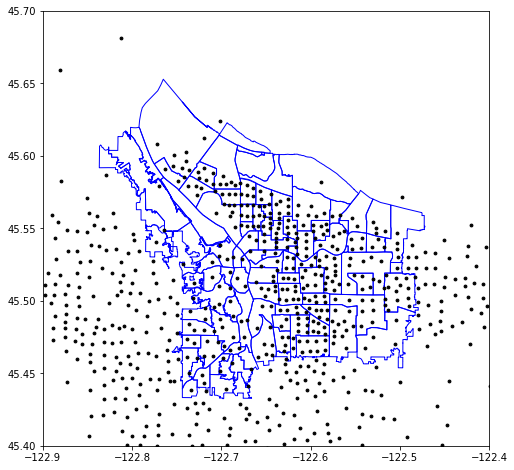

In [108]:
fig, ax = plt.subplots(1, figsize=(8, 8))
disneigh_gdf.plot(ax=ax, edgecolor='b', linewidth=1, facecolor="None")
loss_gdf.plot(ax=ax, color='k', markersize=8)
ax.set_xlim([-122.9, -122.4])
ax.set_ylim([45.4, 45.7])

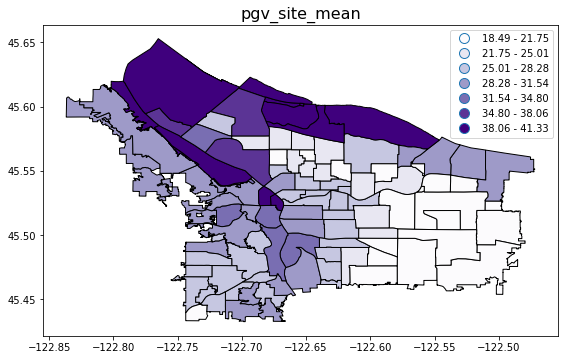

In [12]:
# Plot column value for each geometry contained in gdf
# there is a bug in geopandas plot function when column value
# is categorical and ordered!  Misorders labels and/or omits labels!
col2plot = 'pgv_site_mean'
#help(gdf_merge_class.plot)
categorical = False
savefig = False
if categorical:
    k = None
    scheme = None
else:
    k = 7
    scheme = 'Equal_interval'
    
# Plotting
fig, ax = plt.subplots(1, figsize=(8, 8))
basemap = gdf_merge_class.plot(column=col2plot, cmap='Purples', ax=ax, k=k,
        categorical=categorical, scheme=scheme, legend=True, linewidth=1, edgecolor='k'
)
#basemap = gplt.choropleth(gdf_merge_class, hue=col2plot, projection=gplt.crs.PlateCarree(),
#        cmap='Purples', categorical=categorical, legend=True, linewidth=1, edgecolor='k',
#        legend_labels=['None', 'Low', 'Moderate', 'High', 'Very High']
#)
ax.set_aspect('equal')
ax.set_title(col2plot, fontsize=16)
plt.tight_layout()
if savefig:
    plt.savefig(col2plot+"final.png", bbox_inches='tight', pad_inches=0.1)

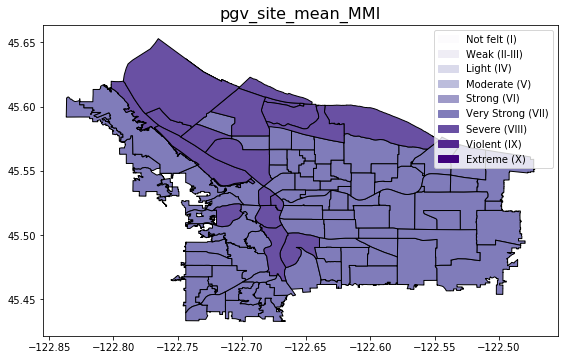

In [14]:
# Plot a single class label within a given categorical column
# This is for categorical data ONLY!
#cmap = plt.cm.Purples(0.5)
#print(cmap)
#colbase = 'PGD_liquefaction_wet'
colbase = 'pgv_site'
col2plot = colbase + '_mean_MMI'
categorical = True
# Plotting
num_labels = len(params['stats_classification'][colbase]['level_labels'])
fig, ax = plt.subplots(1, figsize=(8, 8))
legend_patches = []
import matplotlib.patches as mpatches
for ind, lab in enumerate(params['stats_classification'][colbase]['level_labels']):
    #print(ind/num_labels)
    gdf_catplot = gdf_merge_class.loc[gdf_merge_class[col2plot]==lab, ['geometry', col2plot]]
    #print(gdf_catplot)
    if not gdf_catplot.empty:
        ph = gdf_catplot.plot(color=plt.cm.Purples(ind/(num_labels-1)), ax=ax,
                categorical=categorical, linewidth=1, edgecolor='k', legend=True
        )
    legend_patches.append(mpatches.Patch(color=plt.cm.Purples(ind/(num_labels-1)), label=lab))
ax.set_aspect('equal')
ax.set_title(col2plot, fontsize=16)
ax.legend(handles=legend_patches)
#plt.legend(handles=[red_patch])
#ax.legend(labels=params['stats_classification'][colbase]['level_labels'])
plt.tight_layout()
plt.savefig(col2plot+"final.png", bbox_inches='tight', pad_inches=0.1)